In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

2.0.3
2.13.0


In [2]:
import os, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Dict

import tensorflow as tf
from tensorflow.keras import layers, models

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# (선택) CPU에서 안정적으로 돌리기 위해 쓰레드 수 제한
try:
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
except Exception as e:
    print("[warn] threading setup skipped:", e)

In [3]:
from pathlib import Path

# data 폴더 경로 지정
data_path = Path(r"C:\Users\Administrator\Downloads\yoochoose\data")

# ratings.dat 파일 경로
train_path = data_path / "ratings.dat"

print("절대경로:", train_path.resolve())
print("파일 존재 여부:", train_path.exists())

절대경로: C:\Users\Administrator\Downloads\yoochoose\data\ratings.dat
파일 존재 여부: True


In [4]:
# --- 데이터 로드 ---
def load_data(data_path: Path, nrows=None):
    # ratings.dat (userId::movieId::rating::timestamp)
    df = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                     dtype={0: np.int32, 1: np.int32, 2: np.float32, 3: np.int32},
                     nrows=nrows, engine="python")
    df.columns = ['UserId', 'ItemId', 'Rating', 'Time']  # UTC epoch seconds
    return df

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
display(data.head())
print(data.shape, "| columns:", list(data.columns))

,UserId,ItemId,Rating,Time
31,1,3186,4.0,978300019
22,1,1270,5.0,978300055
27,1,1721,4.0,978300055
37,1,1022,5.0,978300055
24,1,2340,3.0,978300103


(1000209, 4) | columns: ['UserId', 'ItemId', 'Rating', 'Time']


In [5]:
# --- 기본 분석: 사용자 수/아이템 수/평점 통계 ---
n_users = data['UserId'].nunique()
n_items = data['ItemId'].nunique()
print(f"Users: {n_users:,} | Items: {n_items:,}")
print("\nRating describe:")
display(data['Rating'].describe())

Users: 6,040 | Items: 3,706

Rating describe:


count    1.000209e+06
mean     3.581564e+00
std      1.115656e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [6]:
# --- 세션 정의: User의 연속 상호작용 사이 간격이 threshold(기본 1시간)를 넘으면 세션 분리 ---
def to_sessions(df: pd.DataFrame, time_gap_seconds: int = 60*60,  
                min_session_len: int = 2, min_rating: float = None) -> Tuple[List[List[int]], Dict[int, int]]:
    use = df.copy()
    if min_rating is not None:
        use = use[use['Rating'] >= min_rating].copy()

    # 아이템 인덱싱 (ItemId -> 0..n_items-1)
    item2idx = {mid: i for i, mid in enumerate(use['ItemId'].unique())}
    use['item_idx'] = use['ItemId'].map(item2idx)

    sessions: List[List[int]] = []
    # 사용자별 타임라인을 시간 순으로 세션 분할
    for uid, g in use.groupby('UserId', sort=False):
        ts = g['Time'].values
        items = g['item_idx'].values.tolist()
        start = 0
        for i in range(1, len(ts)):
            if ts[i] - ts[i-1] > time_gap_seconds:
                s = items[start:i]
                if len(s) >= min_session_len:
                    sessions.append(s)
                start = i
        s = items[start:]
        if len(s) >= min_session_len:
            sessions.append(s)

    return sessions, item2idx

# 평점 3.5 이상만 긍정 상호작용으로 사용(원하는 경우 조정/해제 가능)
sessions, item2idx = to_sessions(data, time_gap_seconds=3600, min_session_len=2, min_rating=3.5)
print(f"세션 수: {len(sessions):,} | 아이템 수(인덱스화): {len(item2idx):,}")
print("예시 세션 3개:", sessions[:3])

세션 수: 15,194 | 아이템 수(인덱스화): 3,533
예시 세션 3개: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], [45, 46, 47, 48, 49, 8, 50, 51, 52, 53, 7, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 15, 65, 66, 67, 68, 69, 70, 18, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 26, 91, 92, 93, 94, 95, 14, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]]


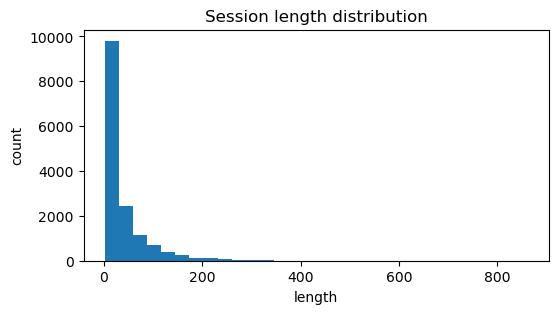

세션 길이 기초 통계: {'count': 15194.0, 'mean': 37.485125707516126, 'std': 54.43420020724312, 'min': 2.0, '25%': 5.0, '50%': 18.0, '75%': 47.0, 'max': 861.0}


In [7]:
# --- 세션 길이 분포 확인 ---
lens = [len(s) for s in sessions]
plt.figure(figsize=(6,3))
plt.hist(lens, bins=30)
plt.title("Session length distribution")
plt.xlabel("length"); plt.ylabel("count")
plt.show()

print("세션 길이 기초 통계:", pd.Series(lens).describe().to_dict())

In [8]:
# --- (입력, 정답) 샘플 생성: [i1]->i2, [i1,i2]->i3 ...
def sessions_to_examples(sessions: List[List[int]]):
    X, y = [], []
    for s in sessions:
        for t in range(1, len(s)):
            X.append(s[:t])
            y.append(s[t])
    return X, y

# --- 패딩 & 마스킹 ---
def pad_sequences(seq_list: List[List[int]], pad_value: int = 0):
    max_len = max(len(s) for s in seq_list)
    arr  = np.full((len(seq_list), max_len), pad_value, dtype=np.int32)
    mask = np.zeros_like(arr, dtype=np.float32)
    for i, s in enumerate(seq_list):
        arr[i, -len(s):]  = s
        mask[i, -len(s):] = 1.0
    return arr, mask

# --- 데이터셋 래퍼 ---
@dataclass
class Dataset:
    X: np.ndarray  # padded sequences
    M: np.ndarray  # mask (1: real, 0: pad)
    y: np.ndarray  # next item index
    n_items: int

def build_dataset(sessions: List[List[int]], n_items: int) -> Dataset:
    X_list, y_list = sessions_to_examples(sessions)
    X_pad, M = pad_sequences(X_list, pad_value=0)  # 0: 패딩 토큰
    y = np.array(y_list, dtype=np.int32)
    return Dataset(X=X_pad, M=M, y=y, n_items=n_items)

# --- 시간 순 분할(간단히 인덱스 기반) ---
def split_sessions(sessions, train_ratio=0.8, valid_ratio=0.1):
    n = len(sessions)
    n_tr = int(n*train_ratio); n_va = int(n*valid_ratio)
    tr = sessions[:n_tr]
    va = sessions[n_tr:n_tr+n_va]
    te = sessions[n_tr+n_va:]
    return tr, va, te

train_s, valid_s, test_s = split_sessions(sessions, 0.8, 0.1)
n_items = len(item2idx)

tr = build_dataset(train_s, n_items)
va = build_dataset(valid_s, n_items)
te = build_dataset(test_s,  n_items)

print("Train:", tr.X.shape, tr.y.shape, "| Valid:", va.X.shape, va.y.shape, "| Test:", te.X.shape, te.y.shape)

Train: (444942, 860) (444942,) | Valid: (53797, 476) (53797,) | Test: (55616, 709) (55616,)


In [9]:
def build_model(n_items: int, emb_dim: int = 64, gru_dim: int = 64, dropout: float = 0.1) -> tf.keras.Model:
    # 입력(시퀀스/마스크)
    seq_in  = layers.Input(shape=(None,), dtype="int32",   name="seq_in")
    mask_in = layers.Input(shape=(None,), dtype="float32", name="mask_in")

    # 임베딩 (0은 패딩으로 예약, mask_zero=True)
    emb = layers.Embedding(input_dim=n_items+1, output_dim=emb_dim, mask_zero=True, name="item_emb")(seq_in)
    # GRU (mask 전달)
    h = layers.GRU(gru_dim, return_sequences=False, name="gru")(emb, mask=tf.cast(mask_in, tf.bool))
    h = layers.Dropout(dropout)(h)
    logits = layers.Dense(n_items, activation=None, name="logits")(h)
    probs = layers.Activation("softmax", name="probs")(logits)

    model = models.Model(inputs=[seq_in, mask_in], outputs=probs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False))
    return model

model = build_model(n_items=n_items, emb_dim=64, gru_dim=64, dropout=0.1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 seq_in (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 mask_in (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 item_emb (Embedding)        (None, None, 64)             226176    ['seq_in[0][0]']              
                                                                                                  
 tf.cast (TFOpLambda)        (None, None)                 0         ['mask_in[0][0]']             
                                                                                              

Epoch 1/5
1739/1739 - 4782s - loss: 6.9446 - val_loss: 6.6206 - 4782s/epoch - 3s/step
Epoch 2/5
1739/1739 - 4813s - loss: 6.3624 - val_loss: 6.2437 - 4813s/epoch - 3s/step
Epoch 3/5
1739/1739 - 5005s - loss: 6.0349 - val_loss: 6.0461 - 5005s/epoch - 3s/step
Epoch 4/5
1739/1739 - 5022s - loss: 5.8534 - val_loss: 5.9372 - 5022s/epoch - 3s/step
Epoch 5/5
1739/1739 - 4451s - loss: 5.7375 - val_loss: 5.8730 - 4451s/epoch - 3s/step


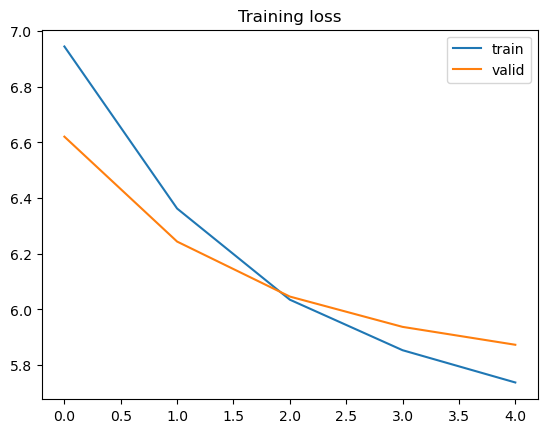

In [10]:
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(x={"seq_in": tr.X, "mask_in": tr.M}, y=tr.y, batch_size=256,
                    epochs=5, validation_data=({"seq_in": va.X, "mask_in": va.M}, va.y),
                    callbacks=[early], verbose=2)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="valid")
plt.title("Training loss")
plt.legend(); plt.show()

In [11]:
def recall_mrr_at_k(probs: np.ndarray, y_true: np.ndarray, k: int = 20):
    # 빠른 top-k: argpartition 후 후보 확인, MRR은 argsort로 랭크 계산
    topk = np.argpartition(-probs, kth=min(k, probs.shape[1]-1), axis=1)[:, :k]
    order = np.argsort(-probs, axis=1)

    recall = 0.0
    mrr = 0.0
    for i in range(len(y_true)):
        t = y_true[i]
        if t in topk[i]: recall += 1.0
        r = np.where(order[i] == t)[0]
        if r.size > 0: mrr += 1.0 / (r[0] + 1)
    n = len(y_true)
    return recall/n, mrr/n

probs = model.predict({"seq_in": te.X, "mask_in": te.M}, batch_size=256, verbose=0)
r20, m20 = recall_mrr_at_k(probs, te.y, k=20)
print(f"Recall@20: {r20:.4f} | MRR@20: {m20:.4f}")

Recall@20: 0.2868 | MRR@20: 0.0797
